In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

data = load_digits()

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X,y = data.data, data.target

In [85]:
print(df.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

<Figure size 432x288 with 0 Axes>

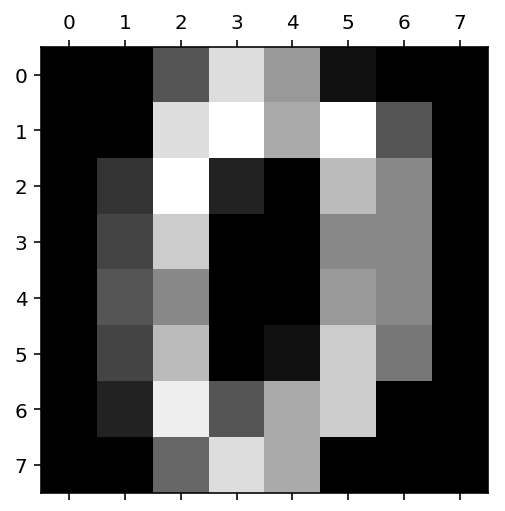

In [86]:
plt.gray()
plt.matshow(data.images[0])
plt.show()

In [87]:
#scaler = StandardScaler()
#X = pd.DataFrame(data=scaler.fit_transform(X))

In [103]:
X = pd.DataFrame(data=X)
features = X.columns
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [104]:
def estimate_accuracy(clf, X, y, cv=10):
    return cross_val_score(clf, X, y, cv=10, n_jobs=8).mean()

In [115]:
tree = DecisionTreeClassifier()
print("Decision tree:", estimate_accuracy(tree, X, y, cv=10))

Decision tree: 0.823119168182


In [116]:
bagging_trees = BaggingClassifier(tree, n_estimators=100)
print("Decision tree bagging:", estimate_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.921023035195


Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии — треть числа признаков.

In [119]:
bagging_random_trees = BaggingClassifier(tree, max_features=int(np.sqrt(len(features))), n_estimators=100)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.930971654617


In [120]:
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=30)
print("Random tree:", estimate_accuracy(random_tree, X, y))

Random tree: 0.757457422864


In [121]:
bagging_random_trees = BaggingClassifier(random_tree, n_estimators=100)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.95494144875


In [136]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=8,
    max_features=int(np.sqrt(len(features))),
    max_depth=30
    )
print("Random Forest:", estimate_accuracy(random_forest, X, y))

Random Forest: 0.951057544996


In [126]:
random_forest = RandomForestClassifier(
    n_estimators=5,
    max_features=int(np.sqrt(len(features))),
    max_depth=30,
    oob_score=True,
    n_jobs=-1
)
random_forest.fit(X, y)
random_forest.oob_score_.mean()

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.74179187534780189

Ещё одно преимущество использования бэггинга для аггрегации моделей — получение оценки работы классификатора без дополнительного проведения **кросс-валидации** при помощи **out-of-bag score**. Это метод вычисления произвольной оценки качества во время обучения бэггинга. Для подсчёта требуется указать параметр **oob_score = True**, что имеет смысл при достаточном количестве деревьев.

Метод бэггинга можно применять к произвольным алгоритмам, например, к логистической регрессии. 

In [16]:
lr = LogisticRegression(solver='saga', max_iter=200)
lr.fit(X, y)
print("LR:", estimate_accuracy(lr, X, y))

LR: 0.441450358867


In [17]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.4371690424


In [18]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    max_features=0.5,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.283769664031


In [57]:
def plot_predictions(X, y, clf, proba=False, points_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data, border=.5):
        #x_std, y_std = data.std(axis=0)
        #x_min, x_max = data[:, 0].min() - x_std / 2, data[:, 0].max() + x_std / 2
        #y_min, y_max = data[:, 1].min() - y_std / 2, data[:, 1].max() + y_std / 2
        x_min, x_max = data.iloc[:, 0].min() - border, data.iloc[:, 0].max() + border
        y_min, y_max = data.iloc[:, 1].min() - border, data.iloc[:, 1].max() + border
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.coolwarm, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return clf

In [59]:
plot_predictions(X, y, random_forest, proba=False)

ValueError: Number of features of the model must match the input. Model n_features is 9 and input n_features is 2 